In [46]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [ ]:
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# python3 -m pip install tensorflow
# # Verify install:
# python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [1]:
# !pip3 install transformers==4.6.0
# !pip install transformers[tf-cpu]


In [2]:
#!pip3 install keras
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import transformers
import tensorflow
import pandas as pd
import numpy as np

from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import pipeline


C:\Users\DrTavassolipour\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# Read data from excel
df_raw = pd.read_excel('data.xls')
df_raw.sample(10)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages
32382,35164,737438,نخ خیاطی اورجینال بسته 24 عددی,MA,8060002,1,0,verified,recommended,راضی بودم,در کل اکی بود,2.0,"[""تنوع رنگ هاش خوب و کاربردی هست. من از خریدش ...",NaN
36135,39444,143920,کفپوش سه بعدی صندوق خودرو بابل مناسب برای پرای...,TC,2422960,2,0,verified,recommended,111کفپوش صندوق,امروز بدستم رسید.\nچیز ردیفیه.پیشنهاد میشه,2.0,NaN,NaN
39305,43072,752385,فیلتر ممبران پنتیر مدل TLC-75,HA,8171208,6,0,verified,\N,کیفیت,کیفیت این فیلتر بسیار عالی بود ممنون,2.0,NaN,NaN
57093,63676,538092,محافظ صفحه نمایش شفاف مدل TPU Full Cover مناس...,AC,808886,1,0,verified,no_idea,پلاستیک شفاف و بی کیفیت,جنسش اصلا خوب نیست و چسبوندنش هم واقعا مصیبته ...,0.0,NaN,NaN
21930,23240,301096,مودم روتر ADSL2 Plus تندا مدل D301v2,IT,7914949,6,3,verified,recommended,امیر,مودم خوبیه و انتظارات منو برآورده میکنه. با زا...,2.0,NaN,NaN
12337,12282,600042,کاور حرارتی سومگ مناسب برای سامسونگ Galaxy S8,AC,1022240,0,2,verified,recommended,فانتزی میخواید بخرید کیفیت میخواید نخرید,عالیییییییی,2.0,"[""تغیر رنگ (البته فقط شبا چون هوا خنک میشه)\r""...","[""بعد یمدت یکمب از قالب خودش درمیاد ولی نه به ..."
37119,40561,134500,هدست استریو بی سیم ال جی مدل Tone Ultra Premiu...,AC,4986618,8,12,verified,\N,ارزش مالی در این حد نیس‌ت,با کمتراز این میشه بهترشو خرید در کل از خریدم ...,0.0,NaN,NaN
12451,12415,321395,گردنبند شهر شیک طرح مرغ آمین مدل G108,FA,646907,0,0,verified,\N,گردنبد مرغ آمین,سلام دوستان . بالاخره به دستم رسید بسیار زیبا ...,2.0,"[""زیبا و چشم نواز""]","[""شاید بدل بودن ""]"
20961,22131,91096,شارژر همراه کملیون مدل PS625F-22DB با ظرفیت 22...,AC,5658248,6,11,verified,not_recommended,بسیار ضعیفه,اصلا راضی نبودم گوشی منو تا 30 درصدم شارژ نکرد...,0.0,"[""برای من نداره""]","[""ضعفه همش""]"
5428,4225,119472,کرم روشن کننده سی گل مدل Herbal حجم 40 میلی لیتر,PC,6314442,1,0,verified,recommended,عالیه,عالیه حتما بخرید,2.0,"[""پوست روشن میکنه""]",NaN


In [10]:
# Clean up and prepare data
df=df_raw.copy()
df.loc[df['recommend']=='recommended'    ,'score']=1
df.loc[df['recommend']=='not_recommended','score']=0

df=df.loc[~df['score'].isna(),['comment','score']].copy()
df=df.sample(1000)
df['istest']=np.random.rand(len(df))<0.2
df.sample(10)

,comment,score,istest
60307,هیچ کدام از ویژگی هاش واقعی نیست و پیشنهاد میک...,0.0,False
54419,عالی بود حرف نداشت,1.0,False
50892,باطریش فقط یه ساعت شارژ میشه و یک ساعت باطری ن...,0.0,True
29428,موس پد خوبیه پیشنهاد میکنم برای خرید پد ماوس ا...,1.0,True
29267,از جنسش راضی بودم و تو تن قشنگه ممنون دیجی,1.0,False
32726,چینیه نخرید الکی نوشتن ایتالیاا,0.0,False
54395,شبیه تصویرش نیست و ساده کار شده است.,0.0,True
40351,از بهترین کتابهایی که خوندم,1.0,False
59382,خداییش من هرچی مارک انکر گرفتم پشیمون نشدم، ای...,1.0,False
46361,خلاصه که عااالی,1.0,False


In [27]:
# prepare feature extraction pipeline
feature_extraction_pipeline = pipeline('feature-extraction',model='HooshvareLab/bert-base-parsbert-uncased')

def extract_features_list(examples):
    features = []
    for i in tqdm(range (len(examples))):
        s=examples[i]
        if(len(s)>1000):# make sure the length of texts is no more than 1000 characters
            s=s[0:1000]
        features.append(feature_extraction_pipeline(s)[0][0])
    features = np.array(features)
    return features


Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
np.array(feature_extraction_pipeline('سلام خوبی؟')).shape

(1, 5, 768)

In [34]:
# extract features
X = extract_features_list(df['comment'].values)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


In [36]:
X.shape

(100, 768)

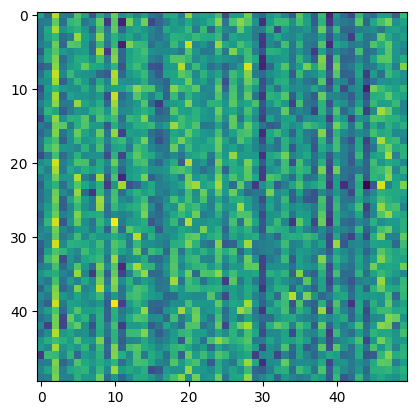

In [13]:
plt.imshow(X[0:50,0:50])

In [37]:
# Train a classifier
y=df['score']
x_train=X[~df['istest']]
x_test =X[ df['istest']]
y_train=y[~df['istest']]
y_test =y[ df['istest']]

model = LogisticRegression( max_iter=1000 ).fit(x_train, y_train)
df['prediction'] = model.predict_proba(X)[:,1]
pred_test = model.predict_proba(x_test)[:,1]

In [38]:
# Examine prediction results
df.loc[df['istest'],['comment','score','istest','prediction']].sort_values(by='prediction')

,comment,score,istest,prediction
34946,عالیههه واقعا,1.0,True,0.067868
61360,تقریبا بی کیفیت ترین چیزی بوده که از digikala ...,0.0,True,0.076126
50892,باطریش فقط یه ساعت شارژ میشه و یک ساعت باطری ن...,0.0,True,0.090942
54395,شبیه تصویرش نیست و ساده کار شده است.,0.0,True,0.126187
15470,من هیچ تاثیری روی موهام حس نکردم، انگار نه انگ...,0.0,True,0.168290
54590,این کالا اصلا ارزش خرید کردن ندارد، بسیار بی ک...,0.0,True,0.449547
18755,برای استفاده روزانه عالیه مثلا پیاده روی یا پش...,1.0,True,0.450880
54361,با عرض سلام و خسته نباشید \nمن مدتی هست که این...,0.0,True,0.498800
38658,اصلا قابل استفاده نیست. من برای خودم و دوتا از...,0.0,True,0.581380
55003,یه جفت گرفتم اما در مقایسه با جم ساز اون خوش س...,0.0,True,0.606707


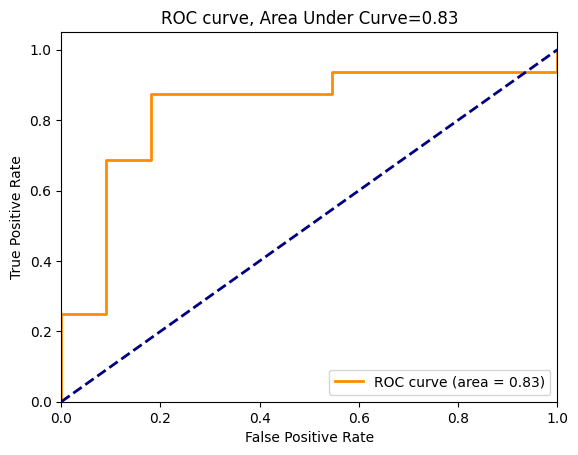

In [39]:
# draw ROC curve
def draw_roc_curve(y_test,pred_test):
    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve, Area Under Curve=%.2f" % roc_auc)
    plt.legend(loc="lower right")

draw_roc_curve(y_test,df.loc[df['istest'],'prediction'])


In [52]:
# query a comment and perform sentiment analysis
comment=input('یک کامنت بنویسید:')
score=model.predict_proba(extract_features_list([comment]))[0,1]
print("score = %.2f" % score)

یک کامنت بنویسید:خووووووبه


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]

score = 0.90
